In [2]:
import pandas as pd
import matplotlib.pyplot as plt

mhealth_apps = pd.read_csv("../data/mhealth_apps.csv")

In [3]:
def extract_unique_item(dataframe):
    unique_items = set()
    for items in dataframe.dropna():
        unique_items.update(str(items).split(", "))
    return unique_items

def filter_data(df):
    usa = ['us']
    europe = [
        'al', 'ad', 'am', 'at', 'az', 'by', 'be', 'ba', 'bg', 'hr', 'cy', 'cz', 'dk', 'ee',
        'fi', 'fr', 'ge', 'de', 'gi', 'gr', 'hu', 'is', 'ie', 'it', 'kz', 'xk', 'lv', 'li',
        'lt', 'lu', 'mt', 'md', 'mc', 'me', 'nl', 'mk', 'no', 'pl', 'pt', 'ro', 'ru', 'sm',
        'rs', 'sk', 'si', 'es', 'se', 'ch', 'ua', 'gb', 'va', 'uk'
    ]
    def country_filter(countries, country_set):
        return any(country.lower() in country_set for country in countries)

    countries_list = df['countries'].str.split(', ').explode()
    usa_europe = set(usa + europe)
    rest_of_world = set(countries_list) - usa_europe
    
    df['country_split'] = df['countries'].str.split(', ')
    us_filtered_df = df[df['country_split'].apply(lambda x: country_filter(x, usa))]
    europe_filtered_df = df[df['country_split'].apply(lambda x: country_filter(x, europe))]
    row_filtered_df = df[df['country_split'].apply(lambda x: country_filter(x, rest_of_world))]

    print('Number of apps available in USA:', len(us_filtered_df))
    print('Number of apps available in Europe:', len(europe_filtered_df))
    print('Number of apps available in RoW:', len(row_filtered_df))
    
    return us_filtered_df, europe_filtered_df, row_filtered_df

In [4]:
usa_df, europe_df, rest_of_world_df = filter_data(mhealth_apps)


Number of apps available in USA: 360
Number of apps available in Europe: 604
Number of apps available in RoW: 811


In [5]:
usa_permissions = extract_unique_item(usa_df['permissions'])
europe_permissions = extract_unique_item(europe_df['permissions'])
rest_of_world_permissions = extract_unique_item(rest_of_world_df['permissions'])

usa_dangerous_permissions = extract_unique_item(usa_df['dangerous_permissions'])
europe_dangerous_permissions = extract_unique_item(europe_df['dangerous_permissions'])
rest_of_world_dangerous_permissions = extract_unique_item(rest_of_world_df['dangerous_permissions'])

rest_of_world_VS_usa = rest_of_world_permissions - usa_permissions
rest_of_world_VS_europe = rest_of_world_permissions - europe_permissions
europe_VS_usa = europe_permissions - usa_permissions

danger_rest_of_world_VS_usa = rest_of_world_dangerous_permissions - usa_dangerous_permissions
danger_rest_of_world_VS_europe = rest_of_world_dangerous_permissions - europe_dangerous_permissions
danger_europe_VS_usa = europe_dangerous_permissions - usa_dangerous_permissions

# Display results
print("Unique permissions to ROW vs. USA (not in USA):")
print("=" * 40)
print("All permissions:")
print(len(rest_of_world_VS_usa))

print("Dangerous permissions:")
print(len(danger_rest_of_world_VS_usa))
for item in danger_rest_of_world_VS_usa:
    print(item)
    
print("\nUnique permissions ROW vs. Europe (not in Europe):")
print("=" * 40)
print("All permissions:")
print(len(rest_of_world_VS_europe))
    
print("Dangerous permissions:")
print(len(danger_rest_of_world_VS_europe))
for item in danger_rest_of_world_VS_europe:
    print(item)

print("\nUnique permissions Europe vs. USA (not in USA):")
print("=" * 40)
print("All permissions:")
print(len(europe_VS_usa))
    
print("Dangerous permissions:")
print(len(danger_europe_VS_usa))
for item in danger_europe_VS_usa:
    print(item)

Unique permissions to ROW vs. USA (not in USA):
All permissions:
394
Dangerous permissions:
3
!android.permission.PROCESS_OUTGOING_CALLS
!com.android.voicemail.permission.ADD_VOICEMAIL
!android.permission.WRITE_CALL_LOG

Unique permissions ROW vs. Europe (not in Europe):
All permissions:
173
Dangerous permissions:
2
!com.android.voicemail.permission.ADD_VOICEMAIL
!android.permission.WRITE_CALL_LOG

Unique permissions Europe vs. USA (not in USA):
All permissions:
236
Dangerous permissions:
1
!android.permission.PROCESS_OUTGOING_CALLS


In [6]:
import matplotlib.pyplot as plt

def count_dangerous_permissions(permission_column):
    counts = []
    for items in permission_column.dropna():
        counts.append(len(set(str(items).split(", "))))
    return counts


total_apps_queried = len(mhealth_apps)
unique_df = mhealth_apps.drop_duplicates(subset='app_id')
total_unique_apps = len(unique_df)
total_apps_by_category = unique_df['categories'].value_counts()
category_percentage = (total_apps_by_category / total_unique_apps * 100).round(2)
unique_danger_permissions = extract_unique_item(unique_df['dangerous_permissions'])
unique_trackers = extract_unique_item(unique_df['trackers'])


def calculate_category_stats(data, column_name):
    stats = []
    grouped = data.groupby('categories')
    for category, group in grouped:
        permission_counts = count_dangerous_permissions(group[column_name])
        stats.append({
            "category": category,
            "mean_permissions": pd.Series(permission_counts).mean(),
            "max_permissions": pd.Series(permission_counts).max(),
            "median_permissions": pd.Series(permission_counts).median(),
            "unique_permissions": len(extract_unique_item(group[column_name]))
        })
    return pd.DataFrame(stats)


category_stats = calculate_category_stats(unique_df, 'dangerous_permissions')
category_stats_sorted = category_stats.sort_values(by='unique_permissions', ascending=False)

top_5_categories = category_stats_sorted.head(5)
others = category_stats_sorted.tail(len(category_stats_sorted) - 5)

others_unique_permissions = set()
for category, group in others.iterrows():
    others_unique_permissions.update(extract_unique_item(unique_df[unique_df['categories'] == group['category']]['dangerous_permissions']))

others_summary = {
    "category": "Others",
    "mean_permissions": others["mean_permissions"].mean(),
    "max_permissions": others["max_permissions"].max(),
    "median_permissions": others["median_permissions"].median(),
    "unique_permissions": len(others_unique_permissions)
}

final_category_stats = pd.DataFrame([*top_5_categories.to_dict(orient='records'), others_summary])
final_category_stats

,category,mean_permissions,max_permissions,median_permissions,unique_permissions
0,Health & Fitness,5.635328,24.0,4.0,50
1,Tools,17.333333,21.0,16.0,28
2,Sports,20.000000,21.0,20.0,22
3,Medical,4.775862,16.0,4.0,22
4,Lifestyle,3.692308,9.0,3.0,17
5,Others,4.764957,11.0,4.0,20


In [8]:
def count_items(dataframe, item_type):
    item_counts = {}
    for items in dataframe.dropna():
        for item in str(items).split(", "):
            if item in item_counts:
                item_counts[item] += 1
            else:
                item_counts[item] = 1
    return item_counts


permissions_counts = count_items(unique_df['dangerous_permissions'], 'dangerous_permissions')
sorted_permissions = sorted(permissions_counts.items(), key=lambda item: item[1], reverse=True)

for key, value in sorted_permissions[:10]:
    print(f'{key:<80} {value}')


!android.permission.WRITE_EXTERNAL_STORAGE                                       404
!android.permission.READ_EXTERNAL_STORAGE                                        369
!android.permission.CAMERA                                                       283
!android.permission.ACCESS_FINE_LOCATION                                         194
!android.permission.ACCESS_COARSE_LOCATION                                       188
!android.permission.RECORD_AUDIO                                                 175
!android.permission.READ_PHONE_STATE                                             137
!android.permission.ACTIVITY_RECOGNITION                                         118
!com.huawei.android.launcher.permission.WRITE_SETTINGS                           106
!com.oppo.launcher.permission.WRITE_SETTINGS                                     105


In [9]:
apps_tracker = mhealth_apps[mhealth_apps['trackers'].notnull()]
print(f'Number of apps with trackers: {len(apps_tracker)} ({len(apps_tracker)/len(mhealth_apps)*100:.2f}%)')

Number of apps with trackers: 564 (65.89%)


In [11]:
trackers_counts = count_items(unique_df['trackers'], 'trackers')
sorted_trackers = sorted(trackers_counts.items(), key=lambda item: item[1], reverse=True)

for key, value in sorted_trackers[:10]:
    print(f'{key:<80} {value}')

Google Firebase Analytics                                                        506
Google CrashLytics                                                               410
Facebook Login                                                                   248
Facebook Share                                                                   219
Facebook Analytics                                                               186
Google AdMob                                                                     174
AppsFlyer                                                                        121
Sentry                                                                           76
Google Analytics                                                                 73
Amplitude                                                                        72


In [12]:
def count_unique_trackers(tracker_column):
    counts = []
    for items in tracker_column.dropna():
        counts.append(len(set(str(items).split(", "))))
    return counts


def calculate_category_stats(data, column_name):
    stats = []
    grouped = data.groupby('categories')
    for category, group in grouped:
        tracker_counts = count_unique_trackers(group[column_name])
        stats.append({
            "category": category,
            "mean_trackers": pd.Series(tracker_counts).mean(),
            "max_trackers": pd.Series(tracker_counts).max(),
            "median_trackers": pd.Series(tracker_counts).median(),
            "unique_trackers": len(extract_unique_item(group[column_name]))
        })
    return pd.DataFrame(stats)


category_stats = calculate_category_stats(unique_df, 'trackers')
category_stats_sorted = category_stats.sort_values(by='unique_trackers', ascending=False)

top_5_categories = category_stats_sorted.head(5)
others = category_stats_sorted.tail(len(category_stats_sorted) - 5)

others_unique_trackers = set()
for category, group in others.iterrows():
    others_unique_trackers.update(extract_unique_item(unique_df[unique_df['categories'] == group['category']]['trackers']))

others_summary = {
    "category": "Others",
    "mean_trackers": others["mean_trackers"].mean(),
    "max_trackers": others["max_trackers"].max(),
    "median_trackers": others["median_trackers"].median(),
    "unique_trackers": len(others_unique_trackers)
}

final_category_stats = pd.DataFrame([*top_5_categories.to_dict(orient='records'), others_summary])
final_category_stats

,category,mean_trackers,max_trackers,median_trackers,unique_trackers
0,Health & Fitness,6.275862,33.0,6.0,135
1,Medical,4.315789,12.0,4.0,70
2,Parenting,8.965517,30.0,8.0,64
3,Simulation,17.000000,31.0,17.0,35
4,Lifestyle,5.083333,12.0,5.5,26
5,Others,6.214815,22.0,4.5,58


In [13]:
import matplotlib.pyplot as plt


def extract_unique_items(dataframe):
    unique_items = set()
    for items in dataframe.dropna():
        unique_items.update(str(items).split(", "))
    return unique_items


def count_items(column):
    counts = []
    for items in column.dropna():
        counts.append(len(set(str(items).split(", "))))
    return counts


total_apps_queried = len(mhealth_apps)
unique_df = mhealth_apps.drop_duplicates(subset='app_id')
total_unique_apps = len(unique_df)


def calculate_category_stats(data):
    stats = []
    grouped = data.groupby('categories')
    for category, group in grouped:
        total_permissions = count_items(group['permissions'])
        dangerous_permissions = count_items(group['dangerous_permissions'])
        trackers = count_items(group['trackers'])

        stats.append({
            "category": category,
            "num_apps": len(group),
            "unique_permissions": len(extract_unique_items(group['permissions'])),
            "unique_dangerous_permissions": len(extract_unique_items(group['dangerous_permissions'])),
            "unique_trackers": len(extract_unique_items(group['trackers']))
        })
    return pd.DataFrame(stats)


category_stats = calculate_category_stats(unique_df)

category_stats_sorted = category_stats.sort_values(by='num_apps', ascending=False)

top_categories = category_stats_sorted.head(5)
other_categories = category_stats_sorted.tail(len(category_stats_sorted) - 5)

others_unique_permissions = set()
others_unique_dangerous_permissions = set()
others_unique_trackers = set()

for _, row in other_categories.iterrows():
    others_unique_permissions.update(extract_unique_items(mhealth_apps[mhealth_apps['categories'] == row['category']]['permissions']))
    others_unique_dangerous_permissions.update(extract_unique_items(mhealth_apps[mhealth_apps['categories'] == row['category']]['dangerous_permissions']))
    others_unique_trackers.update(extract_unique_items(mhealth_apps[mhealth_apps['categories'] == row['category']]['trackers']))

others = {
    "category": "Others",
    "num_apps": other_categories["num_apps"].sum(),
    "unique_permissions": len(others_unique_permissions),
    "unique_dangerous_permissions": len(others_unique_dangerous_permissions),
    "unique_trackers": len(others_unique_trackers)
}

category_stats_final = pd.DataFrame([*top_categories.to_dict(orient="records"), others])
category_stats_final.head(10)

,category,num_apps,unique_permissions,unique_dangerous_permissions,unique_trackers
0,Health & Fitness,536,870,50,135
1,Medical,180,286,22,70
2,Parenting,43,112,15,64
3,Education,25,61,13,22
4,Lifestyle,24,97,17,26
5,Others,48,209,30,62


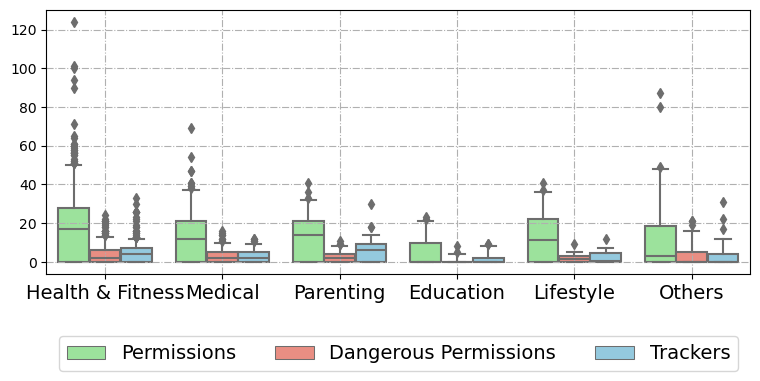

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mhealth_apps = pd.read_csv("../data/mhealth_apps.csv")

category_counts = mhealth_apps['categories'].value_counts()
top_categories = category_counts.nlargest(5).index

mhealth_apps['categories'] = mhealth_apps['categories'].apply(
    lambda x: x if x in top_categories else "Others"
)

category_order = category_counts.loc[top_categories].index.tolist() + ["Others"]

melted_data = mhealth_apps.melt(
    id_vars="categories",
    value_vars=["num_permissions", "num_dangerous_permissions", "num_trackers"],
    var_name="Metric",
    value_name="Value"
)

palette = ["lightgreen", "salmon", "skyblue"]

plt.figure(figsize=(8, 4))

sns.boxplot(
    data=melted_data,
    x="categories", 
    y="Value",   
    hue="Metric",
    order=category_order,
    palette=palette,
    whis=[5, 95],
    hue_order=["num_permissions", "num_dangerous_permissions", "num_trackers"]  # Hue order for legend
)

handles, _ = plt.gca().get_legend_handles_labels()

plt.ylabel("", fontsize=14) 
plt.xlabel("", fontsize=14)  
plt.legend(
    handles=handles, 
    labels=["Permissions", "Dangerous Permissions", "Trackers"], 
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.2), 
    ncol=3,
    fontsize=14 
)
plt.grid(linestyle='-.')
plt.xticks(fontsize=14)

plt.tight_layout()
plt.savefig('../figures/permission_and_trackers.png', bbox_inches='tight')

plt.show()
